In [25]:
import pandas as pd

# Load dataset
df = pd.read_excel('dataset/2022/ACMV-CHL-2-(01012022_1200AM-01072022_1200AM).xlsx')

# Check for duplicates
duplicates = df[df.duplicated(subset=['Timestamp', 'Datasource'], keep=False)]
if not duplicates.empty:
    print(f"Found {len(duplicates)} duplicate rows. Resolving by aggregation.")
    # Resolve duplicates by taking the mean of duplicate entries
    df = df.groupby(['Timestamp', 'Datasource'], as_index=False).mean()

# Pivot the table to wide format
try:
    df_wide = df.pivot(index='Timestamp', columns='Datasource', values='Value')
    df_wide.reset_index(inplace=True)  # Reset index for easier handling
    print("Pivot successful!")
except ValueError as e:
    print(f"Error during pivoting: {e}")

# Forward fill missing values
df_wide.ffill(inplace=True)

# Backward fill missing values (if needed)
df_wide.bfill(inplace=True)

# Display the first few rows of the prepared data
print(df_wide.head())


Found 178 duplicate rows. Resolving by aggregation.
Pivot successful!
Datasource           Timestamp  BUILDING A\CHL\2:=DAILY STARTS  \
0          2022-01-05 22:20:00                             1.0   
1          2022-01-05 22:25:00                             1.0   
2          2022-01-05 22:30:00                             1.0   
3          2022-01-05 22:35:00                             1.0   
4          2022-01-05 22:40:00                             1.0   

Datasource  BUILDING A\CHL\2:=DUTY CYCLE  BUILDING A\CHL\2:CDW FLOW  \
0                                    0.0                   0.197943   
1                                    0.0                   0.197943   
2                                    0.0                   0.204539   
3                                    0.0                   0.187450   
4                                    0.0                   0.195844   

Datasource  BUILDING A\CHL\2:CDW RT  BUILDING A\CHL\2:CDW RWT  \
0                               0.0      

In [26]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_wide.iloc[:, 1:])  # Skip the 'Timestamp' column

# Convert to a NumPy array for sequence creation
data = np.array(normalized_data)

# Define function to create sequences
def create_sequences(data, time_steps=10):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        seq = data[i : i + time_steps]
        label = data[i + time_steps]  # The next time step as the label
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Create sequences
time_steps = 10  # Number of previous time steps to consider
X, y = create_sequences(data, time_steps)

# Split into train and test datasets
split = int(0.8 * len(X))  # 80% for training
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (40557, 10, 18), (40557, 18)
Testing data shape: (10140, 10, 18), (10140, 18)


In [27]:
from tensorflow.keras.layers import Input

# Build the LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Explicit Input layer
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(X_train.shape[2])  # Output layer matches the number of features
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=False
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 64)         │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18)             │           594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,258 (133.82 KB)

 Trainable params: 34,258 (133.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0343 - val_loss: 0.0682
Epoch 2/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0132 - val_loss: 0.0195
Epoch 3/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0074 - val_loss: 0.0107
Epoch 4/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0060 - val_loss: 0.0118
Epoch 5/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0057 - val_loss: 0.0087
Epoch 6/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0048 - val_loss: 0.0100
Epoch 7/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0048 - val_loss: 0.0081
Epoch 8/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0045 - val_loss: 0.0079
Epoch 9/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0046 - val_loss: 0.0068
Epoch 10/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0041 - val_loss: 0.0067
Epoch 11/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0041 - val_loss: 0.0070
Epoch 12/50
1014/1014 ━━━━━━━━

317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Number of anomalies detected: 102


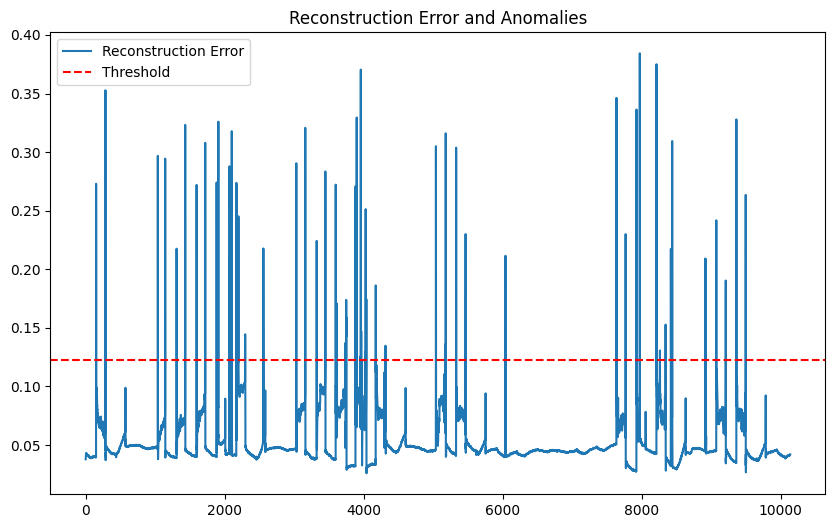

In [28]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the reconstruction error
reconstruction_error = np.mean(np.abs(y_pred - y_test), axis=1)

# mean_error = np.mean(reconstruction_error)
# std_error = np.std(reconstruction_error)
# threshold = mean_error + 2 * std_error

# Define a threshold for anomalies
threshold = np.percentile(reconstruction_error, 99)  # Use the 95th percentile as the threshold

# Identify anomalies
anomalies = reconstruction_error > threshold

print(f"Number of anomalies detected: {np.sum(anomalies)}")

# Visualize the reconstruction error
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title("Reconstruction Error and Anomalies")
plt.show()


In [29]:
# Save the trained model
model.save('lstm_anomaly_detection.h5')


In [30]:
# Extract anomalies' timestamps, datasource, and values
anomaly_indices = np.where(anomalies)[0]
anomaly_timestamps = df_wide.iloc[anomaly_indices + time_steps]['Timestamp']  # Adjust by time_steps

# The datasources are the column names (excluding Timestamp)
anomaly_datasources = df_wide.columns[1:]  # Exclude Timestamp

# Gather the corresponding values for anomalies
anomaly_values = df_wide.iloc[anomaly_indices + time_steps, 1:]  # Adjust by time_steps

# Convert the result into a readable format (DataFrame)
anomalies_df = pd.DataFrame(anomaly_values, columns=anomaly_datasources)
anomalies_df['Timestamp'] = anomaly_timestamps

# Display the anomalies
print(anomalies_df)

Datasource  BUILDING A\CHL\2:=DAILY STARTS  BUILDING A\CHL\2:=DUTY CYCLE  \
160                                    1.0                      0.000000   
294                                   64.0                      0.000000   
1048                                 143.0                      0.479901   
1154                                 143.0                      0.427295   
1318                                 114.0                      0.375186   
...                                    ...                           ...   
8935                                 142.0                      0.000000   
9085                                 143.0                      0.000000   
9221                                 143.0                      0.000000   
9374                                 143.0                      0.000000   
9508                                 143.0                      0.000000   

Datasource  BUILDING A\CHL\2:CDW FLOW  BUILDING A\CHL\2:CDW RT  \
160                  

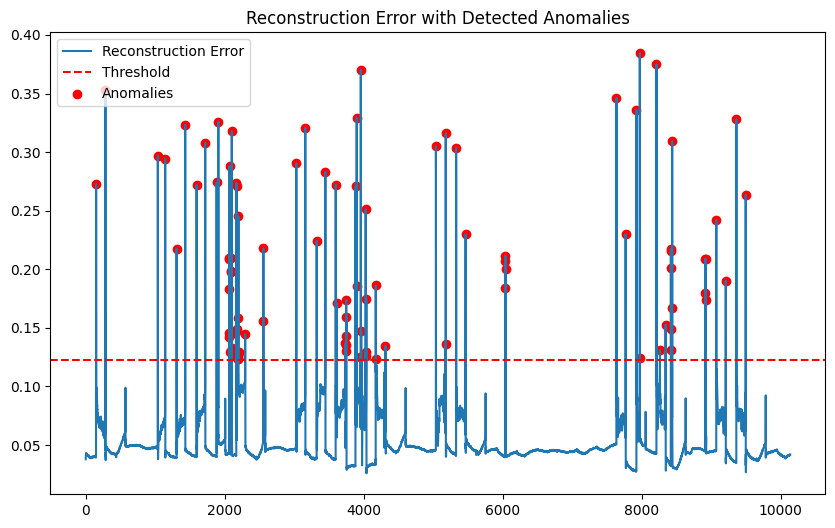

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(anomaly_indices, reconstruction_error[anomaly_indices], color='red', label='Anomalies')
plt.legend()
plt.title("Reconstruction Error with Detected Anomalies")
plt.show()
